In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import RFECV
from sklearn.svm import SVC

In [2]:
train_cli = pd.read_csv('train.csv', index_col=0)
cli=['age','apoe4','gender']
train=train_cli.drop(cli,axis=1)
x_train = train.iloc[:, :-1]
y_train = train.iloc[:, -1]
print('x_train: ' , x_train.shape)

x_train:  (365, 2547)


In [3]:
# name
gene_name=x_train.columns.values
gene_pair=[]
for i in range(0,len(gene_name)):
    for j in range(1,len(gene_name)):
        if (i == j):
            continue
        if j > i:
            gene_pair.append('%s|%s' % (gene_name[j],gene_name[i]))        

In [4]:
# miRNA_pairs
ls=[]
for i in tqdm(range(0,x_train.shape[0])):
    x=np.tile(x_train.iloc[i][:], (x_train.shape[1],1))
    sub = x - x.T #算出各基因对相减数值
    v = sub [np.triu_indices(sub.shape[0], k = 1)].tolist() #取一半（矩阵上三角上移1）
    ls.append(v)
df_gp=pd.DataFrame(ls)
#df #行为样本 列为各基因对相减值 0列x2-x1;1列x3-x1....n-1列xn-x1,n列 x3-x2,n+1列x4-x2....

100%|████████████████████████████████████████████████████████████████████████████████| 365/365 [02:00<00:00,  3.03it/s]


In [5]:
print(df_gp.shape)
df_gp.columns=gene_pair
df_gp.head(3)

(365, 3242331)


,hsa-let-7b-5p|hsa-let-7a-5p,hsa-let-7c-5p|hsa-let-7a-5p,hsa-let-7d-5p|hsa-let-7a-5p,hsa-let-7e-5p|hsa-let-7a-5p,hsa-let-7f-5p|hsa-let-7a-5p,hsa-miR-15a-5p|hsa-let-7a-5p,hsa-miR-16-5p|hsa-let-7a-5p,hsa-miR-17-5p|hsa-let-7a-5p,hsa-miR-17-3p|hsa-let-7a-5p,hsa-miR-18a-5p|hsa-let-7a-5p,...,hsa-miR-8485|hsa-miR-4485-5p,hsa-miR-9500|hsa-miR-4485-5p,hsa-miR-548bb-5p|hsa-miR-4485-5p,hsa-miR-548bb-3p|hsa-miR-4485-5p,hsa-miR-9500|hsa-miR-8485,hsa-miR-548bb-5p|hsa-miR-8485,hsa-miR-548bb-3p|hsa-miR-8485,hsa-miR-548bb-5p|hsa-miR-9500,hsa-miR-548bb-3p|hsa-miR-9500,hsa-miR-548bb-3p|hsa-miR-548bb-5p
0,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.541455,-5.411579,-5.411579,-5.411579,-3.870124,-3.870124,-3.870124,0.000000,0.000000,0.0
1,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.157898,-0.744814,-3.131609,-3.131609,-0.902712,-3.289508,-3.289508,-2.386795,-2.386795,0.0
2,-0.028875,1.55318,0.149456,0.546012,0.83585,0.965755,1.838434,0.723946,1.679002,-0.041658,...,-0.273155,-3.485781,-3.485781,-3.485781,-3.212626,-3.212626,-3.212626,0.000000,0.000000,0.0


In [6]:
# reversed stable miRNA pairs 
control=df_gp.loc[np.where(y_train.values==0)]
patient=df_gp.loc[np.where(y_train.values==1)]
ls=[]
th =0.60 

for i, _ in df_gp.iteritems():
    pc1=sum(control[i]>0)/control.shape[0]
    pc2=sum(control[i]<0)/control.shape[0]
    pc3=sum(control[i]==0)/control.shape[0]
    pp1=sum(patient[i]>0)/patient.shape[0]
    pp2=sum(patient[i]<0)/patient.shape[0]
    pp3=sum(patient[i]==0)/patient.shape[0]
    if pc1 >= th and pp2 >= th:
        ls.append(i)
    elif pc1 >= th and pp3 >= th:
        ls.append(i)
    elif pc2 >= th and pp1 >= th:
        ls.append(i)
    elif pc2 >= th and pp3 >= th:
        ls.append(i)
    elif pc3 >= th and pp1 >= th:
        ls.append(i)
    elif pc3 >= th and pp2 >= th:
        ls.append(i)
print(len(ls))
df_r=df_gp[ls]
df_r.to_csv('.\\df_r.csv')

962


In [7]:
df=pd.DataFrame()
def convert_value(df):
    index=df.columns.values
    df_t=df.values
    df_t[df_t>0]=1
    df_t[df_t<0]=-1
    df_t=pd.DataFrame(df_t)
    df_t.columns=index
    return df_t

In [8]:
gp_tv=convert_value(df_r)

In [9]:
gp_tv.head(3)

,hsa-miR-892b|hsa-miR-19a-3p,hsa-miR-5001-3p|hsa-miR-19a-3p,hsa-miR-1229-3p|hsa-miR-24-3p,hsa-miR-1281|hsa-miR-24-3p,hsa-miR-1976|hsa-miR-24-3p,hsa-miR-3614-5p|hsa-miR-24-3p,hsa-miR-3675-3p|hsa-miR-24-3p,hsa-miR-4539|hsa-miR-24-3p,hsa-miR-4716-5p|hsa-miR-24-3p,hsa-miR-4747-3p|hsa-miR-24-3p,...,hsa-miR-8052|hsa-miR-208a-5p,hsa-miR-6797-3p|hsa-miR-887-5p,hsa-miR-6891-3p|hsa-miR-887-5p,hsa-miR-6786-5p|hsa-miR-6784-5p,hsa-miR-6810-5p|hsa-miR-6786-3p,hsa-miR-6840-3p|hsa-miR-6787-5p,hsa-miR-7155-5p|hsa-miR-6790-3p,hsa-miR-6797-3p|hsa-miR-6795-3p,hsa-miR-7851-3p|hsa-miR-6797-5p,hsa-miR-6872-3p|hsa-miR-6861-3p
0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0
2,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,1.0


In [10]:
random_state=16

In [11]:
#RF  
rf = RandomForestClassifier(random_state=random_state).fit(gp_tv,y_train)
importances = rf.feature_importances_
index = np.argsort(importances)[::-1]
rf_index= index[0:400].tolist()
x_trainfs_rf = gp_tv.iloc[:,rf_index]
for i in range(x_trainfs_rf.shape[1]):
    print('%2d) %-*s %f' % (i+1,50, x_trainfs_rf.columns[i], importances[rf_index[i]]))

 1) hsa-miR-5739|hsa-miR-4728-5p                       0.010865
 2) hsa-miR-4667-5p|hsa-miR-718                        0.009682
 3) hsa-miR-4687-3p|hsa-miR-92a-2-5p                   0.009386
 4) hsa-miR-6813-5p|hsa-miR-5195-3p                    0.009029
 5) hsa-miR-208a-5p|hsa-miR-6127                       0.008817
 6) hsa-miR-6885-3p|hsa-miR-4269                       0.008778
 7) hsa-miR-6862-3p|hsa-miR-4738-3p                    0.008517
 8) hsa-miR-6797-3p|hsa-miR-4253                       0.008496
 9) hsa-miR-5698|hsa-miR-4792                          0.008228
10) hsa-miR-92b-3p|hsa-miR-30d-5p                      0.008102
11) hsa-miR-5698|hsa-miR-3928-3p                       0.007856
12) hsa-miR-6851-3p|hsa-miR-4632-3p                    0.007465
13) hsa-miR-4722-5p|hsa-miR-4298                       0.007306
14) hsa-miR-6786-5p|hsa-miR-6784-5p                    0.007163
15) hsa-miR-6840-3p|hsa-miR-937-5p                     0.007149
16) hsa-miR-3675-3p|hsa-miR-483-5p      

Selected 17 features : ['hsa-miR-4687-3p|hsa-miR-92a-2-5p' 'hsa-miR-6813-5p|hsa-miR-5195-3p'
 'hsa-miR-1908-3p|hsa-miR-5698' 'hsa-miR-5001-3p|hsa-miR-4756-3p'
 'hsa-miR-5001-3p|hsa-miR-1322' 'hsa-miR-5001-3p|hsa-miR-4477a'
 'hsa-miR-5001-3p|hsa-miR-873-5p' 'hsa-miR-5001-3p|hsa-miR-1253'
 'hsa-miR-5001-3p|hsa-miR-3677-3p' 'hsa-miR-5001-3p|hsa-miR-335-3p'
 'hsa-miR-5001-3p|hsa-miR-140-3p' 'hsa-miR-5001-3p|hsa-miR-3976'
 'hsa-miR-6514-5p|hsa-miR-5001-3p' 'hsa-miR-5001-3p|hsa-miR-561-3p'
 'hsa-miR-5001-3p|hsa-miR-4793-5p' 'hsa-miR-5001-3p|hsa-miR-875-3p'
 'hsa-miR-5001-3p|hsa-miR-3148']


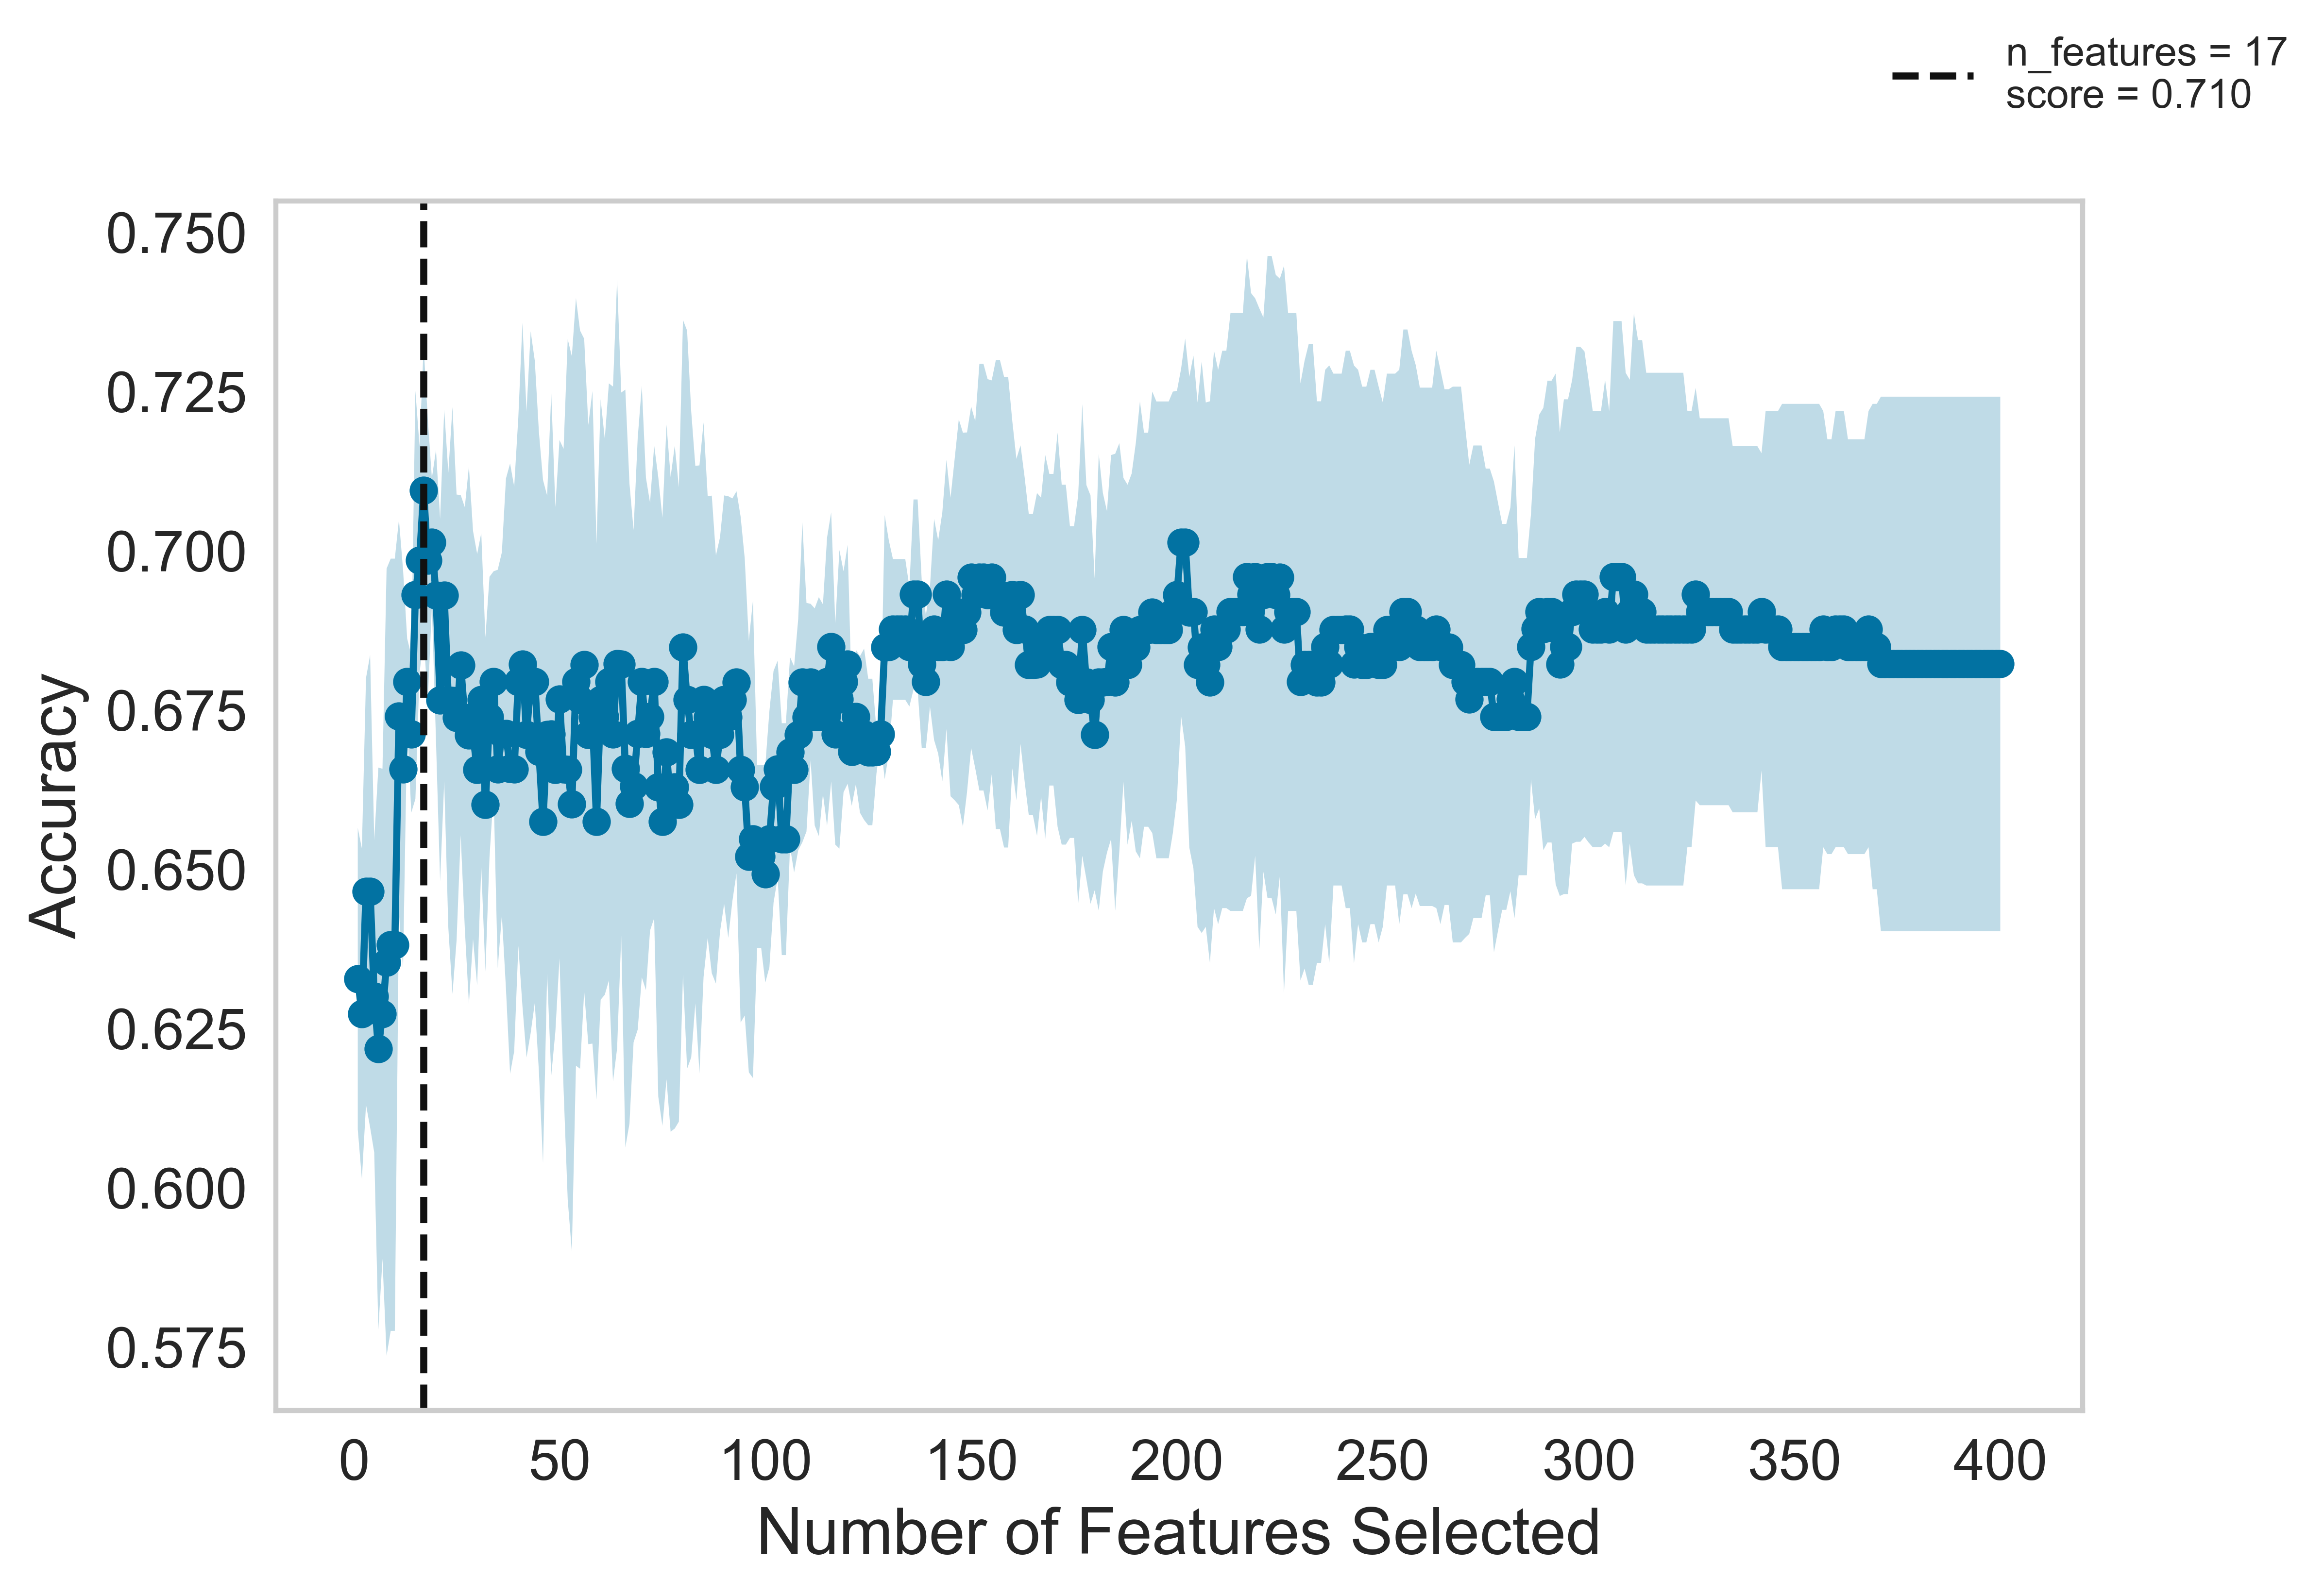

In [12]:
#SVM-RFE-CV
fig = plt.figure(dpi=600)
plt.grid(b=False)
cv=StratifiedKFold(n_splits=3,shuffle=True,random_state=random_state)
visualizer = RFECV(SVC(kernel='linear', C=1),cv = cv,scoring='accuracy')
visualizer.fit(x_trainfs_rf,y_train)
visualizer.ax.set_ylabel("Accuracy",fontsize=16)
visualizer.ax.set_xlabel("Number of Features Selected",fontsize=16)
visualizer.ax.xaxis.set_tick_params(labelsize=14)
visualizer.ax.yaxis.set_tick_params(labelsize=14)
visualizer.fig.legend()
SVMRFECV_index = np.where(visualizer.ranking_== 1)
names_SVMRFECV=np.array(x_trainfs_rf.columns)[SVMRFECV_index[0]]
print('Selected %d features : %s' % (len(names_SVMRFECV),names_SVMRFECV))

In [13]:
fs_colnames=np.array(names_SVMRFECV)
np.save('fs_colnames.npy',fs_colnames)